In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib.pyplot as plt

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples

# Planning:

- refactor code / make it more clear
- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### TODOS:
- Add Tensorboard logging and remove all the prints
- Remove hardcoded num_inducing points (problem: using tf.shape(Z_ph)[0] returns a tensor, variables cannot be initialized with unknown shape)
- Define hyperparameters as variables and add two optimizers with var_lists to optimize with/without hyperparameters 

# Main Graph

In [2]:
def ard_kernel(X1, X2, gamma=1., alphas=None):
    # X1:  (n1 x d)
    # X2:  (n2 x d)
    # out: (n1 x n2
    with tf.name_scope('ard_kernel'):
        if alphas is None:
            alphas = tf.ones([tf.shape(X1)[1]])
        return gamma * tf.reduce_prod(tf.exp(- (tf.expand_dims(X1, 1) - tf.expand_dims(X2, 0))**2 / (2 * tf.expand_dims(tf.expand_dims(alphas, 0), 0))), axis=2) 


def mu_tilde_square(X_data, Z, S, m, Kzz_inv):
    k_zx = ard_kernel( Z,X_data, alphas=a_const)
    k_xz = tf.transpose(k_zx)
    K_xx = ard_kernel(X_data, X_data, alphas=a_const)
    mu_sqr = tf.matmul(tf.matmul(tf.transpose(tf.expand_dims(m,1)),Kzz_inv)
                                                     ,k_zx)**2
 
    sig_sqr = K_xx - tf.matmul(tf.matmul(k_xz,K_zz_inv),k_zx) + tf.matmul(tf.matmul(tf.matmul(tf.matmul(k_xz,Kzz_inv),S),Kzz_inv),k_zx)

    return mu_sqr,sig_sqr

def kl_term(m, S, K_zz, K_zz_inv, u_ovln):
    # mean_diff = (u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m)
    mean_diff = tf.expand_dims(u_ovln * tf.ones([tf.shape(Z_ph)[0]]) - m, 1)
    first  = tf.trace(tf.matmul(K_zz_inv, S))
    second = tf.log(tf.matrix_determinant(K_zz) / tf.matrix_determinant(S))
    third  = tf.to_float(tf.shape(m)[0])
    # fourth = tf.reduce_sum(tf.multiply(tf.reduce_sum(tf.multiply(mean_diff, tf.transpose(K_zz_inv)), axis=1) , mean_diff))
    
    fourth = tf.squeeze(tf.matmul(tf.matmul(tf.transpose(mean_diff), K_zz_inv), mean_diff))
    
    return 0.5 * (first  + second - third + fourth)

def psi_term(Z1, Z2,a,g,Tmin,Tmax):
    z_ovln = (tf.expand_dims(Z1,1)+tf.expand_dims(Z2,0))/2
    a_r = tf.expand_dims(tf.expand_dims(a,0),1)
    
    pi = tf.constant(math.pi)
    
    return (g**2) * tf.reduce_prod(-(tf.sqrt(pi * a_r)/2
                   ) * tf.exp(-tf.pow(tf.expand_dims(Z1,1) - tf.expand_dims(Z2,0),2) / (4 * a_r)
                             ) * (tf.erf((z_ovln-tf.expand_dims(tf.expand_dims(Tmax,0),1))/tf.sqrt(a_r)
                                     ) - tf.erf((z_ovln-tf.expand_dims(tf.expand_dims(Tmin,0),1))/tf.sqrt(a_r))),2)

def T_Integral(m, S, Kzz_inv,psi, g,Tmin, Tmax):

    e_qf = tf.matmul(tf.matmul(tf.matmul(tf.matmul(tf.transpose(tf.expand_dims(m,1)),Kzz_inv),psi),Kzz_inv),tf.expand_dims(m,1))
    T = tf.reduce_prod(Tmax-Tmin)
    var_qf = g * T - tf.trace(tf.matmul(Kzz_inv,psi)) + tf.trace(tf.matmul(tf.matmul(tf.matmul(Kzz_inv,S),Kzz_inv),psi))
    return (e_qf + var_qf)

def G(mu_sqr,sig_sqr_matrix):
    
    sig_sqr = tf.diag_part(sig_sqr_matrix)
    lookup_x = - tf.squeeze(mu_sqr) / (2*sig_sqr)
    
    lookup_table = load_lookup_table()
    return table_lookup_op_parallel(lookup_table, lookup_x)
    
    
def exp_at_datapoints(mu_sqr,sig_sqr,C):
    return tf.reduce_sum(-G(mu_sqr,sig_sqr)+tf.log(mu_sqr/2)-C,axis=1)

In [3]:
tf.reset_default_graph()

## ######### ##
# PLACEHOLDER # 
## ######### ##
Z_ph = tf.placeholder(tf.float32, [None, None], name='inducing_point_locations')
u_ph = tf.placeholder(tf.float32, [],           name='inducing_point_mean')
n_ph = tf.placeholder(tf.int32,   [],           name='number_samples')
X_ph =tf.placeholder(tf.float32, [None, None],  name='input_data')

# TODO: set constants as variables and create two optimizers with var_lists to optimize with/without hyperparams
a_const = tf.ones([1]) # dimension = tf.shape(Z_ph)[1]
g_const = tf.ones([1]) # later we have to define gamma as variable
C = tf.constant(0.57721566)

#Tlims
Tmins = tf.reduce_min(Z_ph, axis=0)
Tmaxs = tf.reduce_max(Z_ph, axis=0)

# TODO: use shape of Z_ph instead? Right now, the number is defined twice (once here, one above in the definition of Z)
num_inducing_points = 11 # tf.shape(Z_ph)[0] 

## ####### ##
# VARIABLES # 
## ####### ##
# mean
m_init = tf.ones([num_inducing_points])
m = tf.Variable(m_init)

# vectorized version of covariance matrix S (ensure valid covariance matrix)
vech_size   = (num_inducing_points * (num_inducing_points+1)) / 2 
vech_indices= tf.transpose(tf_tril_indices(num_inducing_points))
L_vech_init = tf.ones([vech_size])
L_vech = tf.Variable(L_vech_init)
L_shape = tf.constant([num_inducing_points, num_inducing_points])
L_st = tf.SparseTensor(tf.to_int64(vech_indices), L_vech, tf.to_int64(L_shape))
L = tf.sparse_add(tf.zeros(L_shape), L_st)
S = tf.matmul(L, tf.transpose(L))

# kernel calls
K_zz  = ard_kernel(Z_ph, Z_ph, alphas=a_const)
K_zz_inv = tf.matrix_inverse(K_zz)

with tf.name_scope('intergration-over-region-T'):
    psi_matrix = psi_term(Z_ph,Z_ph,a_const,g_const,Tmins,Tmaxs)
    integral_over_T = T_Integral(m,S,K_zz_inv,psi_matrix,g_const,Tmins,Tmaxs)
    
with tf.name_scope('expectation_at_datapoints'):
    mu_t_sqr, sig_t_sqr = mu_tilde_square(X_ph,Z_ph,S,m,K_zz_inv)
    exp_term = exp_at_datapoints(mu_t_sqr,sig_t_sqr,C)
    
with tf.name_scope('KL-divergence'):
    kl_term_op = kl_term(m, S, K_zz, K_zz_inv, u_ph)
    tf.summary.scalar('kl_div', kl_term_op)

with tf.name_scope('calculate_bound'):
    lower_bound = -integral_over_T + exp_term - kl_term_op
    
with tf.name_scope('optimization'):
    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(-lower_bound)

with tf.name_scope('prior_sampling'):
    cov  = K_zz
    mean = u_ph * tf.ones([num_inducing_points])
    ind_point_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(mean, cov)
    samples = ind_point_dist.sample(n_ph)
    
m_grad = tf.gradients(kl_term_op, [m])[0]  
L_vech_grad = tf.gradients(kl_term_op, [L_vech])[0]

    
merged = tf.summary.merge_all()

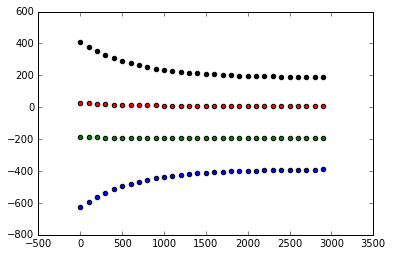

In [9]:
max_iterations = 3000

# inducing point location
Zx = np.linspace(0, 20, 11)[:,na]
Zy = np.linspace(0, 10, 11)[:,na]

Z = np.concatenate((Zx,Zy),axis=1)

X = np.random.rand(10,2)*10

wr_means = []
wr_covar = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    for i in range(max_iterations):
        _, summary, kl, exp_val,mu,sig,integral,bound, m_val, S_val = sess.run([train_step, merged, kl_term_op,exp_term,mu_t_sqr, sig_t_sqr , integral_over_T ,lower_bound, m, S], 
                                                     feed_dict={Z_ph:Z, u_ph:0.,X_ph:X})
        writer.add_summary(summary, i)
        
        if i % 100 == 0:
            #print('..........')
            #print(bound)
            #print("kl:",kl)
            #print("exp:",exp_val)
            #print("integral:",integral)

            #print(sig)
            #print(np.max(np.absolute(S_val)))
            #print(np.all(np.linalg.eigvals(S_val) > 0))
            
            plt.scatter(i, bound,c='b')
            plt.scatter(i, kl,c='r')
            plt.scatter(i, exp_val, c='g')
            plt.scatter(i, integral, c= 'k')
            
        if np.isclose(kl, 0):
            print('KL is zero after {} iterations... break'.format(i))
            break

plt.show()

In [5]:
# numpy ard_kernel calculation
def ard_kernel_np(X1, X2, gamma = 1., alphas = None):
    
    if alphas == None:
        alphas = np.ones(X1.shape[1])
    
    return gamma * np.prod(np.exp( - (X1[:,None,:] - X2[None,:,:])**2 / (2 * alphas[None,None,:])), axis=2)

In [6]:
# TEST

r_mean = np.zeros(num_inducing_points)
r_cov = ard_kernel_np(Z, Z)

print(np.allclose(r_mean, m_val))
print(np.allclose(r_cov, S_val))

print(np.sum(r_cov - S_val)**2)

# values not allclose but almost the same

False
False
12.6238101982


### example sampling:

In [7]:
# sampling
num_samples = 10

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    sample_res, mean_res, cov_res = sess.run([samples, mean, cov], feed_dict={Z_ph:Z, u_ph:0., n_ph:num_samples})

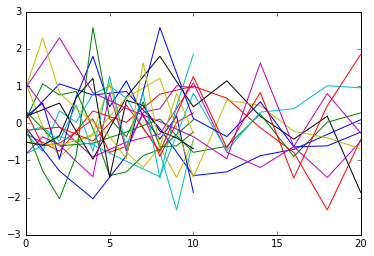

In [8]:
for i in range(num_samples):
    plt.plot(Z, sample_res[i])
plt.show()

## 1-D example: 